# Assignment 2.1 : 2D Heat Equation (Euler Explicit)

In [1]:
import numpy as np
import scipy.linalg as la
from scipy import stats
from scipy.interpolate import interp1d
import scipy
import time
import scipy.io
from scipy.sparse import diags
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import copy
import cv2
from matplotlib.patches import Circle


import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

$$
\frac{\partial T}{\partial t} = \alpha \left(\frac{\partial^2T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}\right)
$$

where $\alpha$ is the thermal diffusivity. This can be solved numerically using the Forward in Time Cenetred in Space (FTCS) method. The stability requirement is $\alpha \frac{\Delta t}{\Delta x^2} + \alpha \frac{\Delta t}{\Delta y^2} \leq \frac{1}{2}$. 


$$
T_{i, j}^{n+1} = T_{i, j}^{n} + \alpha \frac{\Delta t}{\Delta x^2} \left(T_{i-1, j}^{n} - 2T_{i, j}^{n} + T_{i+1, j}^{n} \right) + \alpha \frac{\Delta t}{\Delta y^2} \left(T_{i, j-1}^{n} - 2T_{i, j}^{n} + T_{i, j+1}^{n} \right)
$$


In [2]:
mat = scipy.io.loadmat('matlab_files/gotritons.mat')

In [13]:
# The temperature initial condition.    
T = mat["T"]

# The grid coordinates.
# The domain is assumed to be periodic. 
x = mat["xx"]
y = mat["yy"]

# Delta x and y.
dx = x[1, 0] - x[0, 0]
dy = y[0, 1] - y[0, 0]

# thermal diffusivity 
alpha = 2

# final time 
tf = 0.001

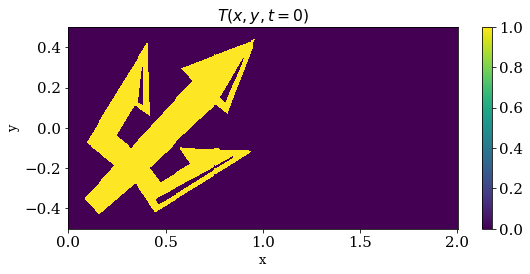

In [18]:
fig, ax = plt.subplots(nrows=1, sharex=True,  figsize=(8, 4))
pos = ax.pcolor(x, y, T,  shading='auto')
fig.colorbar(pos, ax=ax)

_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.set_title(r"$T(x, y, t=0)$")

plt.tight_layout()
plt.savefig("diffusion/initial_condition_tritons.png", dpi=600)

In [31]:
t = np.linspace(0,tf,int(1e3))
dt = t[1] - t[0]
print("CFL = ", alpha*dt/(dx**2) + alpha*dt/(dy**2))

CFL =  0.15896146146146078




$$
T_{i, j}^{n+1} = T_{i, j}^{n} + \alpha \frac{\Delta t}{\Delta x^2} \left(T_{i-1, j}^{n} - 2T_{i, j}^{n} + T_{i+1, j}^{n} \right) + \alpha \frac{\Delta t}{\Delta y^2} \left(T_{i, j-1}^{n} - 2T_{i, j}^{n} + T_{i, j+1}^{n} \right)
$$


In [36]:
def advance_diffusion_eq(Tn, alpha, dx, dy, dt):
    Tnext = np.zeros(Tn.shape)
    for ii in range(Tn.shape[0]):
        for jj in range(Tn.shape[1]):  
            # periodic boundary conditions
            if ii == Tn.shape[0]-1 and jj == Tn.shape[1] -1:
                Tnext[ii, jj] = Tn[ii, jj] + alpha*(dt/dx**2)*(Tn[ii-1, jj] -2*Tn[ii, jj] + Tn[0, jj]) + alpha*(dt/dy**2)*(Tn[ii, jj-1] - 2*Tn[ii, jj] + Tn[ii, 0])           
            elif ii == Tn.shape[0]-1:
                Tnext[ii, jj] = Tn[ii, jj] + alpha*(dt/dx**2)*(Tn[ii-1, jj] -2*Tn[ii, jj] + Tn[0, jj]) + alpha*(dt/dy**2)*(Tn[ii, jj-1] - 2*Tn[ii, jj] + Tn[ii, jj+1])           
            elif jj == Tn.shape[1] -1:
                Tnext[ii, jj] = Tn[ii, jj] + alpha*(dt/dx**2)*(Tn[ii-1, jj] -2*Tn[ii, jj] + Tn[ii+1, jj]) + alpha*(dt/dy**2)*(Tn[ii, jj-1] - 2*Tn[ii, jj] + Tn[ii, 0])
            else:
                Tnext[ii, jj] = Tn[ii, jj] + alpha*(dt/dx**2)*(Tn[ii-1, jj] -2*Tn[ii, jj] + Tn[ii+1, jj]) + alpha*(dt/dy**2)*(Tn[ii, jj-1] - 2*Tn[ii, jj] + Tn[ii, jj+1])
    return Tnext

In [37]:
T_sol = np.zeros((T.shape[0], T.shape[1], len(t)))
T_sol[:, :, 0] = T

for ii in range(len(t) - 1):
    T_sol[:, :, ii+1] = advance_diffusion_eq(T_sol[:, :, ii], alpha, dx, dy, dt)

IndexError: index 1000 is out of bounds for axis 2 with size 1000

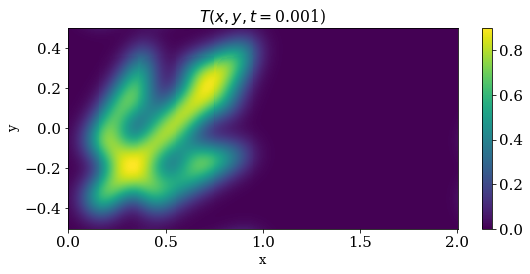

In [42]:
fig, ax = plt.subplots(nrows=1, sharex=True,  figsize=(8, 4))
pos = ax.pcolor(x, y, T_sol[:, :, -1],  shading='auto')
fig.colorbar(pos, ax=ax)

_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.set_title(r"$T(x, y, t=$" + str(tf) + ")")

plt.tight_layout()
plt.savefig("diffusion/final_time_diffusion.png", dpi=600)

# Assignment 2.2: Euler Explicit Advection

$$
\frac{\partial T}{\partial t} = - \bar{c} \cdot \nabla T = - c_{x} \frac{\partial T}{\partial x} - c_{y} \frac{\partial T}{\partial y}
$$

where $\bar{c}$ is the bulk velocity vector. 

In [146]:
mat = scipy.io.loadmat('matlab_files/gotritons.mat')
# The temperature initial condition.    
T = mat["T"]

# The grid coordinates.
# The domain is assumed to be periodic. 
x = mat["xx"]
y = mat["yy"]

# Delta x and y.
dx = x[1, 0] - x[0, 0]
dy = y[0, 1] - y[0, 0]

# First-order backward differences (up to t=2)

In [129]:
tf = 2
t = np.linspace(0,tf,int(1e3))
dt = t[1] - t[0]

cx = 1
cy = 1

print("CFL = ", cx*dt/dx + cy*dt/dy)

CFL =  0.7977977977977961


In [130]:
def advance_diffusion_eq_bkwd(Tn, cx, cy, dx, dy, dt):
    Tnext = np.zeros(Tn.shape)
    for ii in range(Tn.shape[0]):
        for jj in range(Tn.shape[1]):  
            Tnext[ii, jj] = Tn[ii, jj] -cx*(dt/dx)*(Tn[ii, jj] - Tn[ii-1, jj]) -cy*(dt/dy)*(Tn[ii, jj] - Tn[ii, jj-1])
    return Tnext

In [131]:
T_sol = np.zeros((T.shape[0], T.shape[1], len(t)))
T_sol[:, :, 0] = T

for ii in range(len(t) - 1):
    T_sol[:, :, ii+1] = advance_diffusion_eq_bkwd(T_sol[:, :, ii], 1, 1, dx, dy, dt)

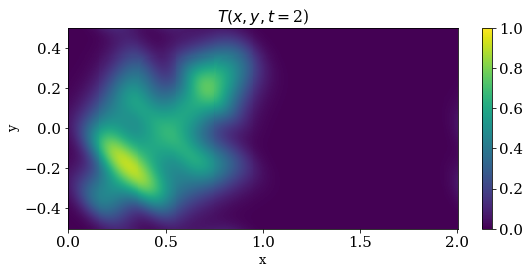

In [132]:
fig, ax = plt.subplots(nrows=1, sharex=True,  figsize=(8, 4))
pos = ax.pcolor(x, y, T_sol[:, :, -1], vmin=0, vmax=1, shading='auto')
fig.colorbar(pos, ax=ax)

_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.set_title(r"$T(x, y, t=$" + str(tf) + ")")

plt.tight_layout()
plt.savefig("diffusion/final_time_advection_backwards.png", dpi=600)

# Second-order central differences (only up to t=0.25)

In [133]:
tf = 0.25

t = np.linspace(0,tf,int(5e2))
dt = t[1] - t[0]

cx = 1
cy = 1

print("CFL = ", cx*dt/dx + cy*dt/dy)

CFL =  0.19964929859719394


In [134]:
def advance_diffusion_eq_central(Tn, cx, cy, dx, dy, dt):
    Tnext = np.zeros(Tn.shape)
    for ii in range(Tn.shape[0]):
        for jj in range(Tn.shape[1]):  
            # periodic boundary conditions
            if ii == Tn.shape[0]-1 and jj == Tn.shape[1]-1:
                Tnext[ii, jj] = Tn[ii, jj] -cx*(dt/dx)*(Tn[0, jj] - Tn[ii-1, jj]) -cy*(dt/dy)*(Tn[ii, 0] - Tn[ii, jj-1])         
            elif ii == Tn.shape[0]-1:
                Tnext[ii, jj] = Tn[ii, jj] -cx*(dt/dx)*(Tn[0, jj] - Tn[ii-1, jj]) -cy*(dt/dy)*(Tn[ii, jj+1] - Tn[ii, jj-1])           
            elif jj == Tn.shape[1]-1:
                Tnext[ii, jj] = Tn[ii, jj] -cx*(dt/dx)*(Tn[ii+1, jj] - Tn[ii-1, jj]) -cy*(dt/dy)*(Tn[ii, 0] - Tn[ii, jj-1])
            else:
                Tnext[ii, jj] = Tn[ii, jj] -cx*(dt/dx)*(Tn[ii+1, jj] - Tn[ii-1, jj]) -cy*(dt/dy)*(Tn[ii, jj+1] - Tn[ii, jj-1])
    return Tnext

In [135]:
T_sol = np.zeros((T.shape[0], T.shape[1], len(t)))
T_sol[:, :, 0] = T

for ii in range(len(t) - 1):
    T_sol[:, :, ii+1] = advance_diffusion_eq_central(T_sol[:, :, ii], 1, 1, dx, dy, dt)

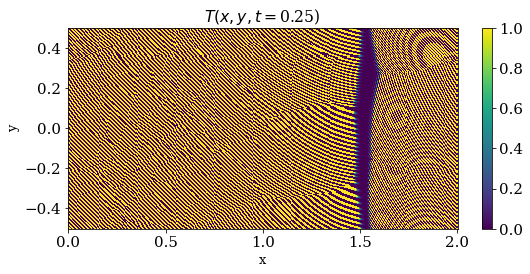

In [136]:
fig, ax = plt.subplots(nrows=1, sharex=True,  figsize=(8, 4))
pos = ax.pcolor(x, y, T_sol[:, :, -1], vmin=0, vmax=1, shading='auto')
fig.colorbar(pos, ax=ax)

_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.set_title(r"$T(x, y, t=$" + str(tf) + ")")

plt.tight_layout()
plt.savefig("diffusion/final_time_advection_central.png", dpi=600)

# Assignment 2.3: MacCormack Advection

In [213]:
tf = 2
t = np.linspace(0,tf,int(1e3))
dt = t[1] - t[0]

cx = 1
cy = 1

print("CFL = ", cx*dt/dx + cy*dt/dy)
print(dx)
print(dy)

CFL =  0.7977977977977961
0.005012531328320802
0.005025125628140725


In [214]:
def advance_diffusion_eq_maccormack(Tn, cx, cy, dx, dy, dt):
    Tnext = np.zeros(Tn.shape)
    
    for ii in range(Tn.shape[0]):
        for jj in range(Tn.shape[1]): 
            if ii == Tn.shape[0] - 1 and jj == Tn.shape[1] -1:
                Ttemp1 = Tn[ii, jj] - cx*(dt/dx)*(Tn[0, jj] - Tn[ii, jj])- cy*(dt/dy)*(Tn[ii, 0] - Tn[ii, jj])
                Ttemp2 = Tn[ii-1, jj] - cx*(dt/dx)*(Tn[ii, jj] - Tn[ii-1, jj]) - cy*(dt/dy)*(Tn[ii-1, 0] - Tn[ii-1, jj])
                Ttemp3 = Tn[ii, jj-1] - cx*(dt/dx)*(Tn[0, jj-1] - Tn[ii, jj-1]) - cy*(dt/dy)*(Tn[ii, jj] - Tn[ii, jj-1])
            
            elif ii == Tn.shape[0] - 1:
                Ttemp1 = Tn[ii, jj] - cx*(dt/dx)*(Tn[0, jj] - Tn[ii, jj])- cy*(dt/dy)*(Tn[ii, jj+1] - Tn[ii, jj])
                Ttemp2 = Tn[ii-1, jj] - cx*(dt/dx)*(Tn[ii, jj] - Tn[ii-1, jj]) - cy*(dt/dy)*(Tn[ii-1, jj+1] - Tn[ii-1, jj])
                Ttemp3 = Tn[ii, jj-1] - cx*(dt/dx)*(Tn[0, jj-1] - Tn[ii, jj-1]) - cy*(dt/dy)*(Tn[ii, jj] - Tn[ii, jj-1])
            
            elif jj == Tn.shape[1] -1:
                Ttemp1 = Tn[ii, jj] - cx*(dt/dx)*(Tn[ii+1, jj] - Tn[ii, jj])- cy*(dt/dy)*(Tn[ii, 0] - Tn[ii, jj])
                Ttemp2 = Tn[ii-1, jj] - cx*(dt/dx)*(Tn[ii, jj] - Tn[ii-1, jj]) - cy*(dt/dy)*(Tn[ii-1, 0] - Tn[ii-1, jj])
                Ttemp3 = Tn[ii, jj-1] - cx*(dt/dx)*(Tn[ii+1, jj-1] - Tn[ii, jj-1]) - cy*(dt/dy)*(Tn[ii, jj] - Tn[ii, jj-1])

            else:
                Ttemp1 = Tn[ii, jj] - cx*(dt/dx)*(Tn[ii+1, jj] - Tn[ii, jj])- cy*(dt/dy)*(Tn[ii, jj+1] - Tn[ii, jj])
                Ttemp2 = Tn[ii-1, jj] - cx*(dt/dx)*(Tn[ii, jj] - Tn[ii-1, jj]) - cy*(dt/dy)*(Tn[ii-1, jj+1] - Tn[ii-1, jj])
                Ttemp3 = Tn[ii, jj-1] - cx*(dt/dx)*(Tn[ii+1, jj-1] - Tn[ii, jj-1]) - cy*(dt/dy)*(Tn[ii, jj] - Tn[ii, jj-1])
            
            Tnext[ii, jj] = 0.5*(Tn[ii, jj] + Ttemp1) -cx*dt/(2*dx)*(Ttemp1-Ttemp2) -cy*dt/(2*dy)*(Ttemp1-Ttemp3)
    return Tnext

In [215]:
T_sol = np.zeros((T.shape[0], T.shape[1], len(t)))
T_sol[:, :, 0] = T

for ii in range(len(t) - 1):
    T_sol[:, :, ii+1] = advance_diffusion_eq_maccormack(T_sol[:, :, ii], 1, 1, dx, dy, dt)

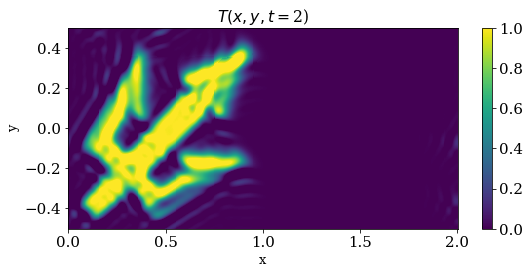

In [216]:
fig, ax = plt.subplots(nrows=1, sharex=True,  figsize=(8, 4))
pos = ax.pcolor(x, y, T_sol[:, :, -1], vmin=0, vmax=1, shading='auto')
fig.colorbar(pos, ax=ax)

_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.set_title(r"$T(x, y, t=$" + str(tf) + ")")

plt.tight_layout()
plt.savefig("diffusion/final_time_advection_maccormack.png", dpi=600)